In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
def gaussian_dist(val, mean, variance):
    temp = - ((val-mean)**2) / (2 * (variance))
    return (1 / (np.sqrt(2 * np.pi* variance)))* np.exp(temp)

def energy(bond_type, distance):
    if bond_type == 1:
        return gaussian_dist(distance, 0.6, .1)
    elif bond_type == 2:
        return gaussian_dist(distance, 0.05, 0.01) 
    else:
        return gaussian_dist(distance, 0.3, 0.02)

### Three functions operating at slightly different length-scales 

The three "bond-types" are in slightly different domains.

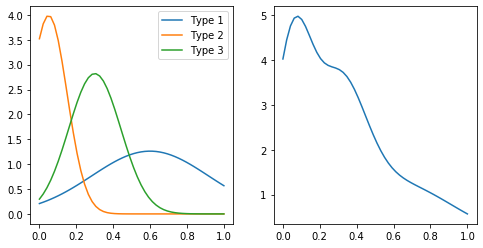

In [3]:
x = np.linspace(0,1)
t1 = energy(1,x)
t2 = energy(2,x)
t3 = energy(3,x)
combined = t1+t2+t3
fig,ax = plt.subplots(1,2,figsize = (8,4))
ax[0].plot(x, t1, label='Type 1')
ax[0].plot(x, t2, label='Type 2')
ax[0].plot(x, t3, label='Type 3')
ax[1].plot(x,combined, label='combined')
ax[0].legend()

In [4]:
x = .6 + np.random.normal(0, scale = .5, size = 10) / 4

## Generate train dataset 

The data is generated as a one-hot encoding of the bond type ([1,0,0], [0,1,0], or [0,0,1],) concatenated with the distance.  

In [5]:
def single_bond_generator(N = 100):
    energies = []
    bond_type = []
    r = np.random.uniform(size=N)
    dist = np.abs(.3 + np.random.normal(0, scale = .5, size = N) / 4)
    for i, num in enumerate(r):
        if (num < .3):
            energies.append(energy(1,dist[i]))
            temp = np.zeros((3))
            temp[0] = 1
            bond_type.append(temp)
        elif (num > .66):
            energies.append(energy(2,dist[i]))
            temp = np.zeros((3))
            temp[1] = 1
            bond_type.append(temp)
        else:
            energies.append(energy(3,dist[i]))
            temp = np.zeros((3))
            temp[2] = 1
            bond_type.append(temp)
    energies = np.array(energies)
    bond_type = np.array(bond_type)
    
    print(energies.shape)
    print(bond_type.shape)
    data = np.concatenate((bond_type, np.expand_dims(dist, axis=1)), axis=1)
    print(data.shape)
    
    return data, energies

In [6]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.utils.data as data_utils

In [7]:
X, y  = single_bond_generator(10000)
data_x = torch.from_numpy(X).float()
data_y = torch.from_numpy(y).float()
dataset = data_utils.TensorDataset(data_x,data_y)


(10000,)
(10000, 3)
(10000, 4)


In [78]:
np.max(X[:,3])

0.7767346427098063

### An example data point

In [8]:
X[0]

array([0.        , 0.        , 1.        , 0.10405717])

## Learning the three different functions with a simple MLP

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Sequential(
                        nn.Linear(4,16),
                        nn.ReLU(),
                        nn.Linear(16,16)
                    )
        self.out = nn.Linear(16,1)
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.out(x)
        return x

In [60]:
tc_set, test_set = torch.utils.data.random_split(dataset, [8000, 2000])
training_set, conformal_set = torch.utils.data.random_split(tc_set, [4000, 4000])
loader = data_utils.DataLoader(training_set, batch_size = 128)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for epoch in range(401):
    total = 0
    for batch, (x,y) in enumerate(loader):
        x = x.to(device)
        out = model(x)
        y = y.to(device).unsqueeze(dim=1)
        loss = loss_func(out, y)
        optimizer.zero_grad()
        loss.backward()
        total += loss.item()
        optimizer.step()
    if (epoch % 100 == 0):
        print(total / len(loader))

1.2381875440478325
0.0007321917892113561
0.0009109439997700974
0.0007511743060604203
0.0007518127849834855


In [62]:
Non_conformity_values = [] 
gamma = 1
conformal_loader = data_utils.DataLoader(conformal_set, batch_size = 1000)
loss_func = nn.L1Loss(reduction='none')
alpha = None
with torch.no_grad():
    for x,y in conformal_loader:
        x = x.to(device)
        print(x.shape)
        out = model(x)
        print(out.shape)
        y = y.unsqueeze(dim=1).to(device)
        print(y.shape)
        alpha = loss_func(out, y)
        print(alpha.shape)

torch.Size([1000, 4])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 4])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 4])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 4])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])


In [63]:
confrm_scores = alpha.squeeze().detach().cpu().numpy()

In [64]:
confrm_scores[:10]

array([0.00666559, 0.02236938, 0.08554006, 0.00361588, 0.06704712,
       0.01750898, 0.02076501, 0.00832074, 0.00253797, 0.03424519],
      dtype=float32)

In [65]:
conform_scores = -np.sort(-confrm_scores)

In [66]:
conform_scores[:10]

array([0.17446399, 0.09369373, 0.08817267, 0.08746409, 0.08664131,
       0.08554006, 0.08449578, 0.0839684 , 0.0832119 , 0.08237553],
      dtype=float32)

In [67]:
mu = np.log(conform_scores)

In [68]:
err = conform_scores[0]

In [69]:
err

0.17446399

(100, 1)


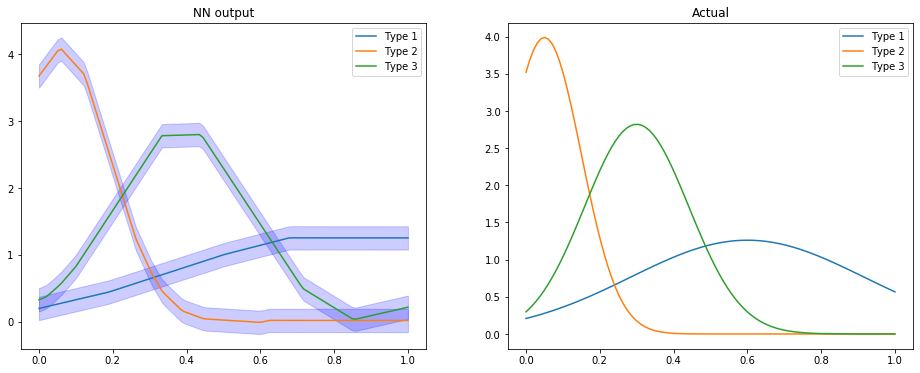

In [79]:
Num_test_samples = 100
x = torch.linspace(0,.77, steps=Num_test_samples).unsqueeze(dim=-1)
class_1 = torch.zeros(Num_test_samples).long()
class_2 = torch.ones(Num_test_samples).long()
class_3 = 2*torch.ones(Num_test_samples).long()

data_1 = torch.cat((F.one_hot(class_1, num_classes=3),x), axis=1)
data_2 = torch.cat((F.one_hot(class_2, num_classes=3),x), axis=1)
data_3 = torch.cat((F.one_hot(class_3, num_classes=3),x), axis=1)

with torch.no_grad():
    t1 = model(data_1.float().to(device)).detach().cpu().numpy()
    t2 = model(data_2.float().to(device)).detach().cpu().numpy()
    t3 = model(data_3.float().to(device)).detach().cpu().numpy()
    
x = np.linspace(0,1, Num_test_samples)
r_t1 = energy(1,x)
r_t2 = energy(2,x)
r_t3 = energy(3,x)
combined = t1+t2+t3
fig,ax = plt.subplots(1,2,figsize = (16,6))
ax[0].plot(x, t1, label='Type 1')
print((t1-err).shape)
ax[0].fill_between(x, np.squeeze(t1-err), np.squeeze(t1+err), color='b', alpha=.2)

ax[0].plot(x, t2, label='Type 2')
ax[0].fill_between(x, np.squeeze(t2-err), np.squeeze(t2+err), color='b', alpha=.2)

ax[0].plot(x, t3, label='Type 3')
ax[0].fill_between(x, np.squeeze(t3-err), np.squeeze(t3+err), color='b', alpha=.2)

ax[1].plot(x, r_t1, label='Type 1')
ax[1].plot(x, r_t2, label='Type 2')
ax[1].plot(x, r_t3, label='Type 3')
ax[0].set_title("NN output")
ax[1].set_title("Actual")
ax[0].legend()
ax[1].legend()

## A slightly more complicated problem

Here we set up a problem, where the nodes in the graph represent different atoms. And depending on the atom type and the distance, the contribution to the total energy of the system is different. 


In [60]:
import torch
from torch_geometric.data import Data, DataLoader

In [153]:
def generate_graph_data(N):
    data_list = []
    for data_sample in range(N):
        node_features = torch.ones((3,1))        
        edge_list = torch.zeros((2,3)).long()
        
        edge_list[0][0] = 0
        edge_list[0][1] = 1
        edge_list[0][2] = 2
        
        edge_list[1][0] = 1
        edge_list[1][1] = 2
        edge_list[1][2] = 0
        
        distances = torch.rand((3,1))
        np_dists = distances.data.cpu().numpy()
        
        edge_features = torch.cat((torch.eye(3), distances), dim=1)
        y = energy(1,np_dists[0][0]) + energy(2,np_dists[1][0])+ energy(3,np_dists[2][0])
        
        node_features = node_features.float()
        edge_list = edge_list.long()
        y = torch.tensor(y).float()
        edge_features = edge_features.float()
        geom_data = Data(x=node_features, edge_index = edge_list, edge_attr = edge_features ,y = y)
        data_list.append(geom_data)
    return data_list

In [154]:
sample = generate_graph_data(1)

In [155]:
sample[0].x

tensor([[1.],
        [1.],
        [1.]])

In [167]:
sample[0].edge_index

tensor([[0, 1, 2],
        [1, 2, 0]])

In [165]:
sample[0].edge_attr

tensor([[1.0000, 0.0000, 0.0000, 0.0529],
        [0.0000, 1.0000, 0.0000, 0.6141],
        [0.0000, 0.0000, 1.0000, 0.7550]])

In [158]:
sample[0].y

tensor(0.2983)

In [159]:
from torch_geometric.data import DataLoader
from torch import nn
from torch_geometric.nn import CGConv, TopKPooling, GCNConv, NNConv
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_add_pool as gaddp

import matplotlib.pyplot as plt

import numpy as np

class Net(torch.nn.Module):
    """docstring for Net"""
    def __init__(self, num_features, mlp=None):
        super(Net, self).__init__()
        
        if mlp is None:
            
            self.g = nn.Sequential(
                nn.Linear(num_features, 128),
                nn.BatchNorm1d(128),
                nn.Dropout(.5),
                nn.ReLU(),
                nn.Linear(128,100),
                nn.BatchNorm1d(100),
                nn.Dropout(.5),
                nn.ReLU(),
                nn.Linear(100,64),
                nn.BatchNorm1d(64),
                nn.Dropout(.5),
                nn.ReLU(),
                nn.Linear(64,16),
                nn.BatchNorm1d(16),
                nn.Dropout(.5),
                nn.ReLU(),
                nn.Linear(16,num_features * num_features)
            )
        else:
            self.g = mlp
        self.conv1 = NNConv(num_features, num_features, self.g, root_weight=False, bias=False)
        self.activ = nn.Tanhshrink()


    def forward(self, data):
        x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = gaddp(x, batch) 
        x = torch.mean(x, dim=1)
        return x

In [160]:
data_list = generate_graph_data(10000)
loader = DataLoader(data_list, batch_size=64)

In [161]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = nn.Sequential(nn.Linear(4,16),
                    nn.ReLU(),
                    nn.Linear(16,1)
                   )
model = Net(1, mlp).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for epoch in range(401):
    total = 0
    for batch, data in enumerate(loader):
        x = data.to(device)
        out = model(x)
        y = data.y.to(device)
        loss = loss_func(out, y)
        optimizer.zero_grad()
        loss.backward()
        total += loss.item()
        optimizer.step()
    if (epoch % 100 == 0):
        print(total / len(loader))

2.1904746574960696
0.0041286547721666135
0.0030558640960378536
0.002359755447350893


(100,)


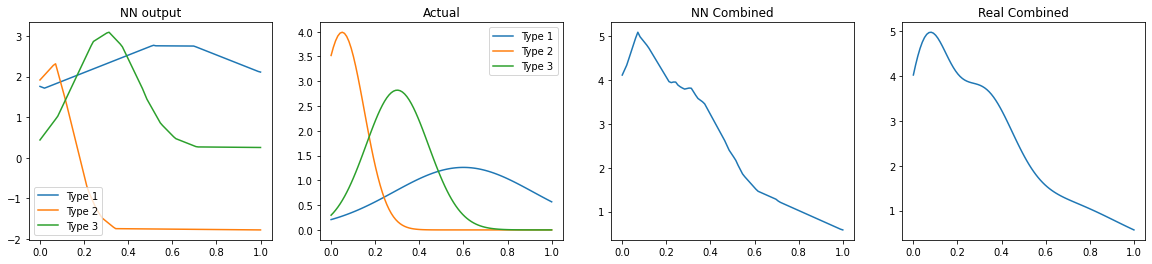

In [166]:
Num_test_samples = 100
x = torch.linspace(0,1, steps=Num_test_samples).unsqueeze(dim=-1)
class_1 = torch.zeros(Num_test_samples).long()
class_2 = torch.ones(Num_test_samples).long()
class_3 = 2*torch.ones(Num_test_samples).long()

data_1 = torch.cat((F.one_hot(class_1, num_classes=3),x), axis=1)
data_2 = torch.cat((F.one_hot(class_2, num_classes=3),x), axis=1)
data_3 = torch.cat((F.one_hot(class_3, num_classes=3),x), axis=1)

with torch.no_grad():
    t1 = np.mean(mlp(data_1.float().to(device)).detach().cpu().numpy(), axis=1)
    t2 = np.mean(mlp(data_2.float().to(device)).detach().cpu().numpy(),axis=1)
    t3 = np.mean(mlp(data_3.float().to(device)).detach().cpu().numpy(),axis=1)
print(t1.shape)
x = np.linspace(0,1, Num_test_samples)
r_t1 = energy(1,x)
r_t2 = energy(2,x)
r_t3 = energy(3,x)
combined = t1+t2+t3
r_combined = r_t1+r_t2+r_t3

fig,ax = plt.subplots(1,4,figsize = (20,4))
ax[0].plot(x, t1, label='Type 1')
ax[0].plot(x, t2, label='Type 2')
ax[0].plot(x, t3, label='Type 3')
ax[1].plot(x, r_t1, label='Type 1')
ax[1].plot(x, r_t2, label='Type 2')
ax[1].plot(x, r_t3, label='Type 3')
ax[0].set_title("NN output")
ax[1].set_title("Actual")

ax[2].plot(x,combined, label = 'NN ')
ax[3].plot(x,r_combined, label='')

ax[2].set_title("NN Combined")
ax[3].set_title("Real Combined")
ax[0].legend()
ax[1].legend()